# Core Geometry Error Testing

In this notebook, I load the data from the same bending experiment as the 4D processing notebook.

I then do the derivations of the shape sensing variables with a custom function which introduces a positioning error of the cores randomly throughout the length. 

The positioning error introduced is propotional to the geometry of the JIP-CALM sensor used to collect this data: $\pm0.8$ mm and the error is introduced in the angular and radial planes.

The error is calculated through the angle(123) and r(123) variables. 

The angle(123) variable is computed as theta_cores(123) + angle_increment (from the original JIPCALM geometry) + a random value -0.094245 < N < 0.094245 rad. This 0.094245 value corresponds to the magnitude of the 0.8mm on a circle of radius r_in = 8.45

The r(123) is computed similarly.

We then reconstruct the curves using the MT and FS methods individually to compare the effects of the positioning error.

In [1]:
# Import all necessary libraries and functions
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../utils')
from functions import *
from plotting import *

In [2]:
# Load the strain data and convert it to a Numpy array
# The data is in the format of (time samples , gauge number) 

datafile = '../../Data/06-02-23-SigTest_data/test_4.txt'
eps = read_strain(datafile)

In [3]:
############## RAW DATA PROCESSING ###############
# Isolate sensor cores segments from the raw data
# Currently this needs to be done manually 
dx = 0.0026
length = 2.1
ns = int(length/dx)
nt = eps.shape[0]

# First core
lim1 = 1160
lim2 = lim1 + ns

# Second core
lim3 = lim2 + 1490
lim4 = lim3 + ns

# Third core
lim5 = lim4 + 1455
lim6 = lim5 + ns

# This is the shape of each core array represented by (time samples , number of gauges)
shape = (nt, ns)

# Populate the core arrays
core1 = np.zeros(shape)
core2 = np.zeros(shape)
core3 = np.zeros(shape)

core1 = eps[:,lim1:lim2]
core2 = eps[:,lim3:lim4]
core3 = eps[:,lim5:lim6]

# Remove and interpolate outliers from the data
c1 = reject_outliers(core1, dx=dx, m=0.1)
c2 = reject_outliers(core2, dx=dx, m=0.1)
c3 = reject_outliers(core3, dx=dx, m=0.1)

# Smoothen the strain data
sc1, sc2, sc3 = smoothen_strain(np.stack((c1,c2,c3)), kernel_size=5)

# Plot the data 
anim = anim_2Dplot(np.array([sc1,sc2,sc3]), -1000, 1000, 500) 

<IPython.core.display.Javascript object>

In [4]:
# Core positioning error proportional to r_in in mm
pos_error = 0.8 
rng = np.random.default_rng()

# Custom function for deriving SS variables with core positioning error
def get_ss_var_error(spl_eps, ds, r_in):
    n_cores = spl_eps.shape[0]   # number of cores in splines
    n_measurements = spl_eps.shape[1]   # number of measurements

    # Initialize arrays
    theta = np.zeros([n_measurements])
    K = np.zeros([n_measurements])

    # Angular distance of cores from horizontal axis (in radians)
    theta_cores = np.zeros((n_cores))

    # Compute the angular position of each core
    for i in range(n_cores):
        theta_cores[i] = ((2 * np.pi * i) / n_cores)
    
    # Compute the angle increment for each measurement and add it to the angular position of each core 
    # This effect is due to core twisting around JIP-CALM sensor
    angle_increment = (np.deg2rad(360) / n_measurements)

    for i in range(n_measurements):
        theta_cores += angle_increment 
        
        ### INDUCE GEOMETRY ERROR
        angle1 =  theta_cores[0] + random.uniform(-0.094245, 0.094245)
        angle2 = theta_cores[1] + random.uniform(-0.094245, 0.094245)
        angle3 = theta_cores[2] + random.uniform(-0.094245, 0.094245)
        
        r1 = r_in + (pos_error * np.sqrt(np.random.random()) *rng.choice((-1,1)))
        r2 = r_in + (pos_error * np.sqrt(np.random.random()) *rng.choice((-1,1)))
        r3 = r_in + (pos_error * np.sqrt(np.random.random()) *rng.choice((-1,1)))

        # Compute the core location matrix M
        M = np.zeros([3, 3])
        
        M[0,:] = np.array([-r1 * np.cos(angle1), r_in * np.sin(angle1), 1])
        M[1,:] = np.array([-r2 * np.cos(angle2), r_in * np.sin(angle2), 1])
        M[2,:] = np.array([-r3 * np.cos(angle3), r_in * np.sin(angle3), 1])
       
        # Compute the pseudo-inverse of M
        cross = np.linalg.pinv(M)

        # Compute the dot product of the location matrix and the strain
        alpha = np.dot(cross, spl_eps[:, i])

        # Compute the angle of bending theta
        theta[i] = np.arctan(alpha[1] / alpha[0])
      
        # Compute the curvature K
        K[i] = np.sqrt(alpha[0] ** 2 + alpha[1] ** 2)
     
    # Compute the direction of bending tau
    tau = np.gradient(np.abs(theta), ds)

    # Compute the radius of curvature R
    R = 1 / K

    # Compute the twist angle phi
    phi = ds / R

    # Return variable arrays
    return theta, K, phi, R, tau

In [5]:
from numpy import random
# Convert all variables to mm
r_in = 8.45                    # r_in is in mm
ds = dx*10**3                    # dx was in m

# Combine core strains into a single array
s = np.stack((sc1, sc2, sc3))   
strain = (s/10**6)           # eps was in microstrain

# Initialize variable arrays for correct positioning example
theta = np.zeros(shape)
K = np.zeros(shape)
phi = np.zeros(shape)
R = np.zeros(shape)
tau = np.zeros(shape)

# Initialize variable arrays for positioning error example
theta_err = np.zeros(shape)
K_err = np.zeros(shape)
phi_err = np.zeros(shape)
R_err = np.zeros(shape)
tau_err = np.zeros(shape)

for i in range(nt):
    theta[i,:], K[i,:], phi[i,:], R[i,:], tau[i,:] = get_ss_var(strain[:,i,:], ds, r_in)
    theta_err[i,:], K_err[i,:], phi_err[i,:], R_err[i,:], tau_err[i,:] = get_ss_var_error(strain[:,i,:], ds, r_in)

In [6]:
plt.close()

# provide original frame directions for Frener-Serret method
r_0 = [0,0,0]
N_0 = [1,0,0]                                
T_0 = [0,0,1]

start = 25
stop = 775
size = stop-start

# Initialise path arrays, here we cropped the edges of the sensor where the result is unstable
r_FS = np.zeros((nt, size+1, 3))
r_MT = np.zeros((nt, size, 4))

r_FS_err = np.zeros((nt, size+1, 3))
r_MT_err = np.zeros((nt, size, 4))

# Perform shape sensing using the Frener-Serret and Matrix_Transform methods
for i in range(nt):
    r_FS[i,:,:] = Frenet_Serret(ds, K[i,start:stop], tau[i,start:stop], T_0, N_0, r_0) 
    r_MT[i,:,:] = Matrix_Transform(tau[i,start:stop], R[i,start:stop], phi[i,start:stop], ds)
    
    r_FS_err[i,:,:] = Frenet_Serret(ds, K_err[i,start:stop], tau_err[i,start:stop], T_0, N_0, r_0) 
    r_MT_err[i,:,:] = Matrix_Transform(tau_err[i,start:stop], R_err[i,start:stop], phi_err[i,start:stop], ds)

In [7]:
# compare curve
path_info(r_FS[-1,:], 'r_FS correct')
path_info(r_FS_err[-1,:], 'r_FS error')

path_info(r_MT[-1,:], 'r_MT correct')
path_info(r_MT_err[-1,:], 'r_MT error')

Shape of r_FS correct (751, 3) with physical length 1949.9729954758418
Shape of r_FS error (751, 3) with physical length 1949.303212926828
Shape of r_MT correct (750, 4) with physical length 1947.3999974298335
Shape of r_MT error (750, 4) with physical length 1947.3999973864682


In [8]:
rot_FS = np.zeros(r_FS.shape)
rot_MT = np.zeros((r_MT.shape[0], r_MT.shape[1], 3) )

rot_FS_err = np.zeros(r_FS_err.shape)
rot_MT_err = np.zeros((r_MT_err.shape[0], r_MT_err.shape[1], 3) )

for i in range(nt):
    rot_FS[i,:,:] = rotate_curve(r_FS[i,:,:])
    rot_MT[i,:,:] = rotate_curve(r_MT[i,:,:3])
    
    rot_FS_err[i,:,:] = rotate_curve(r_FS_err[i,:,:])
    rot_MT_err[i,:,:] = rotate_curve(r_MT_err[i,:,:3])

#transform from millimeter to centimeter    
rot_FS = rot_FS/10
rot_MT = rot_MT/10

rot_FS_err = rot_FS_err/10
rot_MT_err = rot_MT_err/10

In [12]:
# plot xyz values individually over time
anim=xyzdif_aniplots(rot_MT, rot_MT_err, name1='correct positioning', name2='positioning error')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


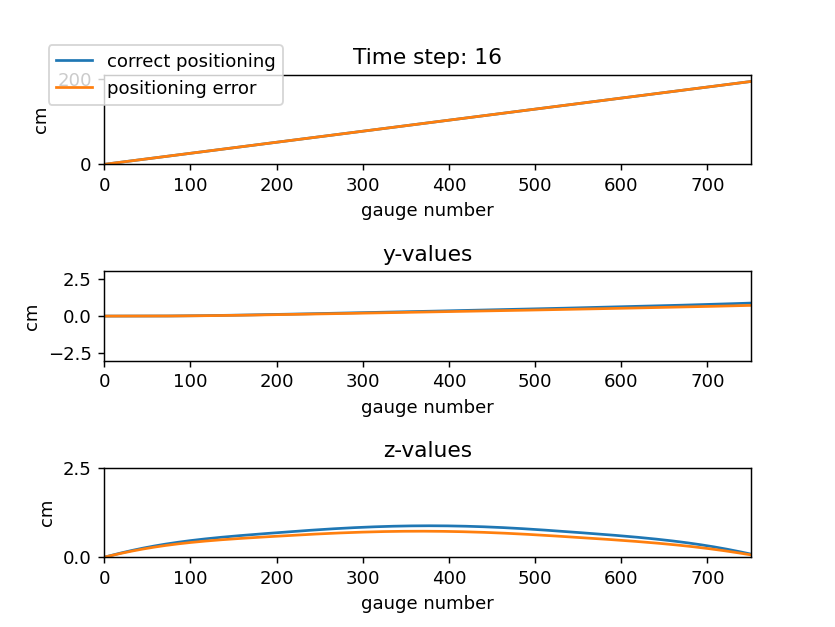

In [14]:
# plot xyz values individually over time
anim=xyzdif_aniplots(rot_FS, rot_FS_err, name1='correct positioning', name2='positioning error')

<IPython.core.display.Javascript object>


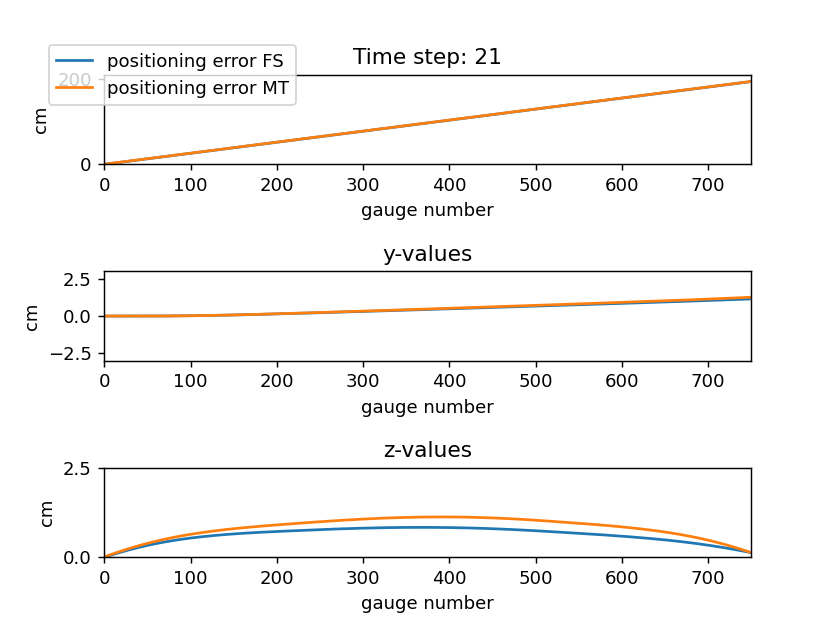

In [15]:
# plot xyz values individually over time
anim=xyzdif_aniplots(rot_FS_err[:,:-1,:], rot_MT_err, name1='positioning error FS', name2='positioning error MT')